[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# 스트리밍(Sstreaming)

## 복습

모듈 2에서는 그래프 상태와 메모리를 사용자 정의하는 몇 가지 방법을 다뤘습니다.

장기간 대화를 지속할 수 있는 외부 메모리를 가진 챗봇을 구축하는 단계까지 진행했습니다.

## 목표

이 모듈에서는 메모리를 기반으로 구축되어 사용자가 다양한 방식으로 그래프와 직접 상호작용할 수 있게 해주는 `human-in-the-loop`에 대해 자세히 살펴보겠습니다.

`human-in-the-loop`의 기반을 마련하기 위해, 먼저 실행 과정에서 그래프 출력(예: 노드 상태 또는 채팅 모델 토큰)을 시각화하는 여러 방법을 제공하는 스트리밍에 대해 자세히 알아보겠습니다.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## 스트리밍

LangGraph는 [스트리밍에 대한 최상위 지원](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)으로 구축되었습니다.

모듈 2의 챗봇을 설정하고, 실행 중에 그래프에서 출력을 스트리밍하는 다양한 방법을 보여드리겠습니다.

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

Python 3.11 미만에서 토큰 단위 스트리밍을 활성화하기 위해 `call_model`과 함께 `RunnableConfig`를 사용한다는 점에 유의하세요. 이는 [Python < 3.11에서만 필요합니다](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). Python 3.x를 사용하는 CoLab에서 이 노트북을 실행하는 경우를 대비하여 포함했습니다.

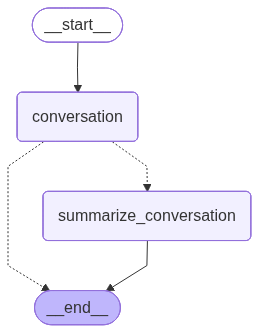

In [11]:
from typing import Annotated, Optional
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)


# State
class State(MessagesState):
    summary: Annotated[Optional[str], "summary"]


# 모델 호출 로직 정의
def call_model(state: State, config: RunnableConfig):
    # 요약이 존재하면 가져오기
    summary = state.get("summary", "")

    # 요약이 있다면 추가합니다
    if summary:
        # 시스템 메시지에 요약 추가
        system_message = f"이전 대화 요약: {summary}"

        # 요약문을 최신 메시지에 추가하십시오
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}


def summarize_conversation(state: State):
    # 먼저, 기존 요약문을 가져옵니다.
    summary = state.get("summary", "")

    # 요약 프롬프트 생성
    if summary:
        # 요약본이 이미 존재합니다
        summary_message = (
            f"지금까지의 대화 요약입니다: {summary}\n\n"
            "위의 새로운 메시지를 고려하여 요약을 확장하십시오.:"
        )

    else:
        summary_message = "위의 대화 내용을 요약하세요.:"

    # 우리의 기록에 프롬프트를 추가하세요
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 가장 최근의 2개 메시지를 제외한 모든 메시지를 삭제하세요
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# 대화를 종료할지 요약할지 결정하십시오
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # 메시지가 여섯 개 이상일 경우 대화를 요약합니다
    if len(messages) > 6:
        return "summarize_conversation"

    # 그렇지 않으면 그냥 끝낼 수 있다
    return END


workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.set_entry_point("conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        END: END,
    },
)
workflow.set_finish_point("summarize_conversation")

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 전체 상태 스트리밍

이제 [그래프 상태를 스트리밍](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)하는 방법에 대해 알아보겠습니다.

`.stream`과 `.astream`은 결과를 스트리밍하여 반환하는 동기 및 비동기 메서드입니다.

LangGraph는 [그래프 상태](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)에 대해 몇 가지 [다른 스트리밍 모드](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)를 지원합니다:

* `values`: 각 노드가 호출된 후 그래프의 전체 상태를 스트리밍합니다.
* `updates`: 각 노드가 호출된 후 그래프 상태의 업데이트만을 스트리밍합니다.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

`stream_mode="updates"`를 살펴보겠습니다.

`updates`로 스트리밍하기 때문에, 그래프의 각 노드가 실행된 후의 상태 업데이트만을 볼 수 있습니다.

각 `chunk`는 `node_name`을 키로 하고 업데이트된 상태를 값으로 하는 딕셔너리입니다.

In [12]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": "1"})
input = State(
    messages=[HumanMessage(content="안녕하세요! 저는 랜스입니다.")],
    summary="",
)
for chunk in graph.stream(input, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='안녕하세요, 랜스님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CLgUL4F1KbNCeJGGEgN5nqaACaIYm', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--cacb66a0-82ec-4a79-8b6f-f5d53a0b310b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


이제 state update를 출력해 보겠습니다.

In [14]:
for chunk in graph.stream(input, config, stream_mode="updates"):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

안녕하세요, 랜스님! 만나서 반갑습니다. 어떻게 도와드릴까요?


이제 `stream_mode="values"`를 볼 수 있습니다.

이것은 `conversation` 노드가 호출된 후의 그래프의 `full state`입니다.

In [ ]:
# 대화를 새로 시작합니다.
config = RunnableConfig(configurable={"thread_id": "2"})

# 대화 시작
input_message = HumanMessage(content="안녕하세요! 저는 랜스입니다.")
for event in graph.stream(
    {"messages": [input_message], "summary": ""},
    config,
    stream_mode="values",
):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

안녕하세요! 저는 랜스입니다.
---------------------------------------------------------------------------
================================ Human Message =================================

안녕하세요! 저는 랜스입니다.
================================== Ai Message ==================================

안녕하세요, 랜스님! 만나서 반갑습니다. 어떻게 도와드릴까요?
---------------------------------------------------------------------------


### 스트리밍 토큰

우리는 종종 그래프 상태보다 더 많은 것을 스트리밍하고 싶어합니다.

특히, 채팅 모델 호출 시 토큰이 생성되는 대로 스트리밍하는 것이 일반적입니다.

우리는 [`.astream_events` 메서드를 사용하여](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node) 이를 수행할 수 있습니다. 이 메서드는 노드 내부에서 발생하는 이벤트를 실시간으로 스트리밍합니다!

각 이벤트는 몇 개의 키를 가진 딕셔너리입니다:

* `event`: 방출되는 이벤트의 유형입니다.
* `name`: 이벤트의 이름입니다.
* `data`: 이벤트와 연관된 데이터입니다.
* `metadata`: 이벤트를 방출하는 노드인 `langgraph_node`를 포함합니다.

살펴보겠습니다.

In [17]:
config = RunnableConfig(configurable={"thread_id": "3"})

input_message = HumanMessage(content="49ers NFL 팀에 대해 알려주세요.")

async for event in graph.astream_events(
    {"messages": [input_message]}, config, version="v2"
):
    print(
        f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}"
    )

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

핵심은 그래프 내 채팅 모델에서 나오는 토큰들이 `on_chat_model_stream` 타입을 가진다는 것입니다.

`event['metadata']['langgraph_node']`를 사용하여 스트리밍할 노드를 선택할 수 있습니다.

그리고 `event['data']`를 사용하여 각 이벤트의 실제 데이터를 가져올 수 있으며, 이 경우에는 `AIMessageChunk`입니다.

In [21]:
config = RunnableConfig(configurable={"thread_id": "4"})

async for event in graph.astream_events(
    {"messages": [HumanMessage(content="49ers NFL 팀에 대해 알려주세요.")]},
    config,
    version="v2",
):
    # 특정 노드(conversation)로부터 토큰 청크을 가져와서 출력합니다.
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == "conversation"
    ):
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='샌', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='프', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='란', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='시', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='스', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content='코', additional_kwargs={}, response_metadata={}, id='run--aa01674d-bcc2-4d92-a1f9-429d6524421b')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id

위에서 볼 수 있듯이, `AIMessageChunk`를 가져오려면 그냥 `chunk` 키를 사용하면 됩니다.

In [22]:
config = RunnableConfig(configurable={"thread_id": "5"})
input_message = HumanMessage(content="49ers NFL 팀에 대해 알려주세요.")

async for event in graph.astream_events(
    {"messages": [input_message]},
    config,
    version="v2",
):
    # 특정 노드로부터 채팅 모델 토큰을 가져옵니다 특정 노드에서 채팅 모델 토큰을 가져옵니다
    if (
        event["event"] == "on_chat_model_stream"
        and event["metadata"].get("langgraph_node", "") == "conversation"
    ):
        data = event["data"]
        print(data["chunk"].content, end="", flush=True)

샌프란시스코 포티나이너스(San Francisco 49ers)는 미국 프로 풋볼 리그(NFL)의 팀 중 하나로, 캘리포니아주 샌타클래라에 본거지를 두고 있습니다. 팀은 1946년에 창단되었으며, NFL의 내셔널 풋볼 컨퍼런스(NFC) 서부 지구에 속해 있습니다. 포티나이너스는 NFL 역사상 가장 성공적인 팀 중 하나로, 여러 차례 슈퍼볼 우승을 차지한 바 있습니다.

### 주요 정보:
- **슈퍼볼 우승**: 포티나이너스는 총 5번의 슈퍼볼에서 우승했습니다. (1981, 1984, 1988, 1989, 1994 시즌)
- **팀 컬러**: 빨간색, 금색
- **홈구장**: 리바이스 스타디움(Levi's Stadium), 2014년부터 사용
- **주요 라이벌**: 댈러스 카우보이스, 시애틀 시호크스, 그린베이 패커스 등

### 역사:
포티나이너스는 1980년대와 1990년대 초반에 걸쳐 전성기를 누렸으며, 이 시기에 조 몬타나(Joe Montana), 제리 라이스(Jerry Rice), 스티브 영(Steve Young)과 같은 전설적인 선수들이 활약했습니다. 이들은 팀의 성공에 크게 기여하며 NFL 역사에 길이 남을 명성을 쌓았습니다.

### 최근 동향:
최근 몇 년간 포티나이너스는 다시 경쟁력 있는 팀으로 자리매김하기 위해 노력하고 있으며, 젊은 선수들과 유능한 코칭 스태프를 통해 팀의 재건을 도모하고 있습니다. 2019 시즌에는 슈퍼볼 LIV에 진출하기도 했습니다.

포티나이너스는 전통과 혁신을 겸비한 팀으로, 팬들에게 많은 사랑을 받고 있습니다.

### LangGraph API를 이용한 스트리밍

이 모듈의 `/studio` 디렉토리에서 터미널에 다음 명령어를 실행하세요:

```sh
langgraph dev
```

다음과 같은 출력이 표시됩니다:

```sh
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

브라우저를 열고 Studio UI로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`

LangGraph API는 [그래프 상태 편집을 지원합니다](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation).

In [ ]:
from langgraph_sdk import get_client

client = get_client(url="http://127.0.0.1:2024")

# 호스팅된 모든 그래프 검색
assistants = await client.assistants.search()
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-10-01T02:35:53.227003+00:00',
  'updated_at': '2025-10-01T02:35:53.227003+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-10-01T02:35:53.225400+00:00',
  'updated_at': '2025-10-01T02:35:53.225400+00:00',
  'version': 1,
  'description': None}]

이전과 마찬가지로 [`values`를 stream](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/)해 봅시다.

In [26]:
# 새 스레드 생성
thread = await client.threads.create()
thread

{'thread_id': '986a79bf-bf35-4760-af78-1bd7c8b9c40e',
 'created_at': '2025-10-01T02:38:22.436546+00:00',
 'updated_at': '2025-10-01T02:38:22.436553+00:00',
 'metadata': {},
 'status': 'idle',
 'config': {},
 'values': None}

In [ ]:
# 입력 메시지
input_message = HumanMessage(content="2와 3을 곱하세요")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="values",
):
    print(event)

StreamPart(event='metadata', data={'run_id': '01999da1-b945-7206-96ef-fc92e99cee6e', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': '2와 3을 곱하세요', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a83361fa-7675-4b43-b55a-7cf425ead090', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': '2와 3을 곱하세요', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a83361fa-7675-4b43-b55a-7cf425ead090', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_P4bxodhJaiggSZwH2PRt99FX', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 136, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_detai

스트리밍된 객체는 다음을 가집니다:

* `event`: Type
* `data`: State

In [27]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="2와 3을 곱하세요")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="values",
):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=" * 25)

content='2와 3을 곱하세요' additional_kwargs={} response_metadata={} id='3f7ebb4b-6063-4d09-b283-e3a69a0deb61'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 136, 'output_tokens': 17, 'total_tokens': 153, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_4RjqGX74fSOsXo0BeNWZ1Bqx', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 136, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CLh1w4zFXHAPLhhHN4mElAdsOPHjv', 'service_tier': 'default', 'finish_reason': 'tool_calls', '

API를 통해서만 지원되는 몇 가지 새로운 스트리밍 모드가 있습니다.

예를 들어, 위의 사례를 더 잘 처리하기 위해 [`messages` 모드를 사용](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/)할 수 있습니다!

이 모드는 현재 그래프에 메시지 목록인 `messages` 키가 있다고 가정합니다.

`messages` 모드를 사용하여 방출되는 모든 이벤트에는 두 가지 속성이 있습니다:

* `event`: 이벤트의 이름입니다
* `data`: 이벤트와 관련된 데이터입니다

In [29]:
thread = await client.threads.create()
input_message = HumanMessage(content="2와 3을 곱하세요")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    print(event)

StreamPart(event='metadata', data={'run_id': '01999da4-de67-7347-8d4d-a9f8c46427e6', 'attempt': 1})
StreamPart(event='messages/metadata', data={'run--a2f07abf-c6b2-4202-83da-ebf8ed1c40bb': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.6.8', 'langgraph_api_version': '0.4.31', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'langgraph_auth_user_id': '', 'langgraph_request_id': '737d7e76-ccce-4fce-918c-eefbfbeddc3d', 'run_id': '01999da4-de67-7347-8d4d-a9f8c46427e6', 'thread_id': '1ad38d6e-e314-4a6b-8819-ecefa8c6bd85', 'user_id': '', 'langgraph_step': 1, 'langgraph_node': 'assistant', 'langgraph_triggers': ['branch:to:assistant'], 'langgraph_path': ['__pregel_pull', 'assistant'], 'langgraph_checkpoint_ns': 'assistant:ec5e892a-031b-0263-ebd7-8b5b311042e0', 'checkpoint_ns': 'assistant:ec5e892a-031b-0263-ebd7-8b5b311042e0'

몇 가지 이벤트를 확인할 수 있습니다:

* `metadata`: 실행에 대한 메타데이터
* `messages/complete`: 완전히 형성된 메시지
* `messages/partial`: 채팅 모델 토큰

타입에 대한 자세한 내용은 [여기](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)에서 확인할 수 있습니다.

이제 이러한 메시지를 스트리밍하는 방법을 보여드리겠습니다.

메시지의 도구 호출을 더 잘 포맷하기 위한 헬퍼 함수를 정의해보겠습니다.

In [30]:
thread = await client.threads.create()
input_message = HumanMessage(content="2와 3을 곱하세요")


def format_tool_calls(tool_calls):
    """
    도구 호출 목록을 가독성 있는 문자열로 포맷팅합니다.

    Args:
        tool_calls (list): 각각 도구 호출을 나타내는 사전 목록입니다.
            각 사전에는 'id', 'name', 'args' 키가 포함되어야 합니다.

    Returns:
        str: 도구 호출의 형식화된 문자열 또는 목록이 비어 있을 경우 "No tool calls".
    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"


async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    # 메타데이터 이벤트 처리
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # 부분 메시지 이벤트 처리
    elif event.event == "messages/partial":
        for data_item in event.data:
            # 사용자 메시지 처리
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # 이벤트에서 관련 데이터를 추출하십시오
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 01999da5-81f2-7293-99a7-d12f26baefdb
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_PcB7gHPRL9OtCBURtupv0txj, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal